In [1]:
import sys; sys.path.insert(0, '../../')
from definitions import *
from notebooks.nb_imports import *

In [2]:
from experiments.utils import create_run_frame
from experiments.analyse import analyse
from src.visualization.critical_difference import plot_cd_diagram, wilcoxon_holm

This notebook is to give an example of how to analyse the experiment output. Note the results given are on a subset of the data and is just meant for explanatory purposes. These are **not** the full results on all datasets that are given in the paper. 


# Experiment evaluation as a single function
Here we give a brief overview of how to extract the information from an experiment run, and how to produce the CD-diagram plots as seen in the paper. 

We actually provide a handy function for analysing the data below, but we give also the steps used in generating this, in case you wish to do something more specialised/some additional analysis to what was given in the paper. 

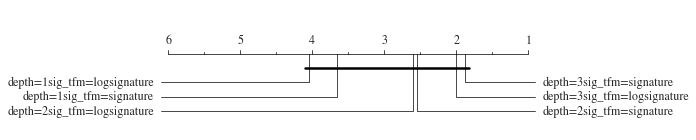

In [3]:
# This saves the test accuracy results, average ranks, and cd-diagram plots to an analysis folder in the experiment directory. 
ex_dir, config_name = RESULTS_DIR + '/depth_sig', 'depth_sig'
results, average_ranks = analyse(ex_dir, config_name)

In [4]:
results.head()

transform_id,depth=1sig_tfm=logsignature,depth=1sig_tfm=signature,depth=2sig_tfm=logsignature,depth=2sig_tfm=signature,depth=3sig_tfm=logsignature,depth=3sig_tfm=signature
ds_name,,,,,,
ArticularyWordRecognition,0.823333,0.833333,0.966667,0.963333,0.986667,0.973333
AtrialFibrillation,0.400000,0.400000,0.333333,0.400000,NaN,NaN
BasicMotions,0.625000,0.575000,1.000000,1.000000,NaN,NaN
CharacterTrajectories,0.402507,0.408078,0.872563,0.875348,0.942201,0.945682
Cricket,0.319444,0.319444,0.986111,0.972222,1.000000,0.972222


<br>
<br>

# Experiment evaluation in individual steps

## 1. Extract the experiment information

Start by creating a dataframe for the run that contains all configuration and metrics information.

In [5]:
df = create_run_frame(RESULTS_DIR + '/depth_sig')
df.head()

,ds_name,acc.test,acc.train,augment_out,clf,depth,disintegrations,ds_dim,ds_length,error,...,rescaling,sanity_dim,save_best_model,scaling,sig_tfm,tfms,train_test_split,training_time,verbose,window
1,Cricket,0.319444,0.879630,None,rf,1,None,6,1197,NaN,...,pre,100000.0,False,stdsc,signature,['addtime'],original,0.271582,2,"['Global', {}]"
2,Cricket,0.319444,1.000000,None,rf,1,None,6,1197,NaN,...,pre,100000.0,False,stdsc,logsignature,['addtime'],original,0.970485,2,"['Global', {}]"
3,ArticularyWordRecognition,0.833333,1.000000,None,rf,1,None,9,144,NaN,...,pre,100000.0,False,stdsc,signature,['addtime'],original,1.037782,2,"['Global', {}]"
4,ArticularyWordRecognition,0.823333,1.000000,None,rf,1,None,9,144,NaN,...,pre,100000.0,False,stdsc,logsignature,['addtime'],original,2.417308,2,"['Global', {}]"
5,CharacterTrajectories,0.408078,0.839662,None,rf,1,None,3,182,NaN,...,pre,100000.0,False,stdsc,signature,['addtime'],original,1.740877,2,"['Global', {}]"


## 2. Create a unique `transform_id` column

This example is for the `depth_sig` configuration where we are interested in the performance for different depths with the signature and logsignature transformations.

Here we have varied the `depth` and `sig_tfm` variables. So first make a column `transform_id` that works as a unique identifier of these two things. 

In [6]:
df['transform_id'] = df['sig_tfm'].astype(str) + df['depth'].astype(str)

## 3. Take a maximum over the classifiers
We took the accuracy to be a maximum over the classifiers. Doing this reduces onto one entry for each unique `ds_name` and `transform_id` column. 

In [7]:
results = df.groupby(['ds_name', 'transform_id', 'clf'])['acc.test'].apply(max)
results = results.reset_index([1, 2]).drop('clf', axis=1)

## 4. Pivot to make a results matrix

Now we have a unique value for every `transform_id` and dataset. We just now need to get `transform_id` to be the column, and `ds_name` to be the index generating a 2x2 matrix of results, then we can generate the CD diagram.

In [8]:
pivoted = results.pivot_table(values='acc.test', index='ds_name', columns='transform_id', aggfunc=np.max)

This pivoted table is now in the form of the tables we give in the Appendix of the paper. 

In [9]:
pivoted.head()

transform_id,logsignature1,logsignature2,logsignature3,signature1,signature2,signature3
ds_name,,,,,,
ArticularyWordRecognition,0.823333,0.966667,0.986667,0.833333,0.963333,0.973333
AtrialFibrillation,0.400000,0.333333,NaN,0.400000,0.400000,NaN
BasicMotions,0.625000,1.000000,NaN,0.575000,1.000000,NaN
CharacterTrajectories,0.402507,0.872563,0.942201,0.408078,0.875348,0.945682
Cricket,0.319444,0.986111,1.000000,0.319444,0.972222,0.972222


## 5. Plot the CD-diagram

The `pivoted` table is in the format where we can use the `plot_cd_diagram` function, these are the results that is seen the paper.

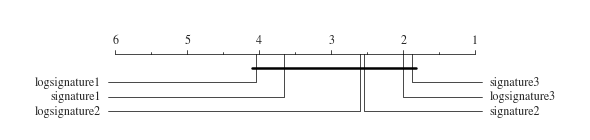

In [10]:
plot_cd_diagram(pivoted)

We can also extract the average ranks for each method, these correspond to the 'Average ranks' column that is given in all the tables in the Appendix of the paper. 

In [11]:
_, scores = wilcoxon_holm(pivoted)
scores

transform_id
signature3       1.875
logsignature3    2.000
signature2       2.550
logsignature2    2.600
signature1       3.650
logsignature1    4.050
dtype: float64